# LIM forecasting: Sea ice 

Katie Brennan  
started March 31, 2020  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
#sys.path.append("/Users/hakim/gitwork/LMR_python3")
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")

In [2]:
# Define of the name of the variable to use for the LIM
#var_to_extract = 'tas'
# tos is not working due to mask issues...
var_to_extract = 'sic'

# number of EOFs to retain for the LIM state vector
nmodes = 20

# forecast lead time in months that defines the LIM training
tau = 3

# training data defined by the first ntrain times
ntrain = 4000

# for the LIM readme
data_source = 'CCSM4 last millennium simulation'

In [3]:
from netCDF4 import Dataset, date2num, num2date
import numpy as np
import ESMF
import LMR_utils
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point

In [4]:
import time as timestamp # avoids conflict with local naming!

In [5]:
pi = np.pi

# fill continents if plotting SST; otherwise no
if var_to_extract == 'tos':
    noland = True
else:
    noland = False
    
# netcdf file locations
#ccsm_dir = '/Users/hakim/data/LMR_python3/data/model/ccsm4_last_millenium/'
ccsm_dir = '/home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/'

infile_ccsm_sic = (ccsm_dir + 'sic_sfc_OImon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_tos = (ccsm_dir + 'tos_sfc_Omon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_tas = (ccsm_dir + 'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_z500 = (ccsm_dir + 'zg_500hPa_Amon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_pr = (ccsm_dir + 'pr_sfc_Amon_CCSM4_past1000_085001-185012.nc')

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

In [6]:
def load_data(var_to_extract,infile):
    
    """This function does all of the gridded data loading and processing"""
    
    print('fetching ',var_to_extract,' from ',infile)
    
    # open the file
    data = Dataset(infile,'r')
    
    # this block hacked from load_gridded_data

    # Dimensions used to store the data
    nc_dims = [dim for dim in data.dimensions]
    dictdims = {}
    for dim in nc_dims:
        dictdims[dim] = len(data.dimensions[dim])

    # Query its dimensions
    vardims = data.variables[var_to_extract].dimensions
    nbdims  = len(vardims)
    # names of variable dims
    vardimnames = []
    for d in vardims:
        vardimnames.append(d)

    # put everything in lower case for homogeneity
    vardimnames = [item.lower() for item in vardimnames]

    # extract info on variable units
    units = data.variables[var_to_extract].units

    # time variable
    time = data.variables['time']

    # Transform into calendar dates using netCDF4 variable attributes (units & calendar)
    try:
        if hasattr(time, 'calendar'):
            # if time is defined as "months since":not handled by datetime functions
            if 'months since' in time.units:
                new_time = np.zeros(time.shape)
                nmonths, = time.shape
                basedate = time.units.split('since')[1].lstrip()
                new_time_units = "days since "+basedate        
                start_date = pl.datestr2num(basedate)        
                act_date = start_date*1.0
                new_time[0] = act_date
                for i in range(int(nmonths)): #increment months
                    d = pl.num2date(act_date)
                    ndays = monthrange(d.year,d.month)[1] #number of days in current month
                    act_date += ndays
                    new_time[i] = act_date

                time_yrs = num2date(new_time[:],units=new_time_units,calendar=time.calendar)
            else:                    
                time_yrs = num2date(time[:],units=time.units,
                                calendar=time.calendar)
        else:
            time_yrs = num2date(time[:],units=time.units)
        time_yrs_list = time_yrs.tolist()
        
    except ValueError:
        # num2date needs calendar year start >= 0001 C.E. (bug submitted
        # to unidata about this
        fmt = '%Y-%d-%m %H:%M:%S'
        tunits = time.units
        since_yr_idx = tunits.index('since ') + 6
        year = int(tunits[since_yr_idx:since_yr_idx+4])
        year_diff = year - 1
        new_start_date = datetime(1, 1, 1, 0, 0, 0)

        new_units = tunits[:since_yr_idx] + '0001-01-01 00:00:00'
        if hasattr(time, 'calendar'):
            time_yrs = num2date(time[:], new_units, calendar=time.calendar)
        else:
            time_yrs = num2date(time[:], new_units)

        time_yrs_list = [datetime(d.year + year_diff, d.month, d.day,
                                  d.hour, d.minute, d.second)
                         for d in time_yrs]
        
    # this loads the data
    begin_time = timestamp.time()
    data_var = data.variables[var_to_extract][:]
    elapsed_time = timestamp.time() - begin_time
    print('-----------------------------------------------------')
    print('completed in ' + str(elapsed_time) + ' seconds')
    print('-----------------------------------------------------')
    
    return data, data_var, vardimnames, time_yrs

In [7]:
def set_coord_names(data, data_var, vardimnames):
    # coordinate setup
    varspacecoordnames = [item for item in vardimnames if item != 'time'] 
    varspacecoordnames = [item for item in varspacecoordnames if item != 'plev'] 
    spacecoords = (varspacecoordnames[0],varspacecoordnames[1])
    spacevar1 = data.variables[spacecoords[0]][:]
    spacevar2 = data.variables[spacecoords[1]][:]
    vardims = data_var.shape
    print(vardims)

    # which dim is lat & which is lon?
    indlat = spacecoords.index('lat')
    indlon = spacecoords.index('lon')
    print('indlat=', indlat, ' indlon=', indlon)

    ntime = len(data.dimensions['time'])

    print(spacecoords)

    if var_to_extract == 'tos':
        lat_2d_orig = spacevar1
        lon_2d_orig = spacevar2
    else:
        lat_2d_orig = spacevar1[:,np.newaxis]*np.ones(spacevar2[:,np.newaxis].shape[0])
        lon_2d_orig = np.ones([spacevar1[:,np.newaxis].shape[0],1])*spacevar2
    
    return ntime, lat_2d_orig, lon_2d_orig

In [8]:
def regrid_data(data_var, ntime, lat_2d_orig, lon_2d_orig, nlat, nlon):
    #----- regrid the data to lower resolution
    begin_time = timestamp.time()
    
    nlat_orig = lat_2d_orig.shape[0]
    nlon_orig = lon_2d_orig.shape[1]
    print('nlat:',nlat_orig)
    print('nlon:',nlon_orig)

    datax = np.reshape(data_var,[ntime,nlat_orig*nlon_orig])
    # shift to (nx,nens) shaping for regridding function
    tmp = np.moveaxis(datax,0,-1)
    print(tmp.shape)

    # this is the new grid
#     nlat = 45
#     nlon = 72
    ndof = nlat*nlon
    nens = ntime

    # regrid using LMR regrid function, which uses ESMpy
    [data_new,
     lat_2d,
     lon_2d] = LMR_utils.regrid_esmpy(nlat,
                                       nlon,
                                       nens,
                                       tmp,
                                       lat_2d_orig,
                                       lon_2d_orig,
                                       nlat_orig,
                                       nlon_orig)

    elapsed_time = timestamp.time() - begin_time
    print('-----------------------------------------------------')
    print('completed in ' + str(elapsed_time) + ' seconds')
    print('-----------------------------------------------------')
    
    return data_new, lat_2d, lon_2d

In [9]:
def compute_climo(data_new, time_yrs, ntime, nlat, nlon): 
    # compute monthly average and remove from the original data
    dates = time_yrs

    # shape back back to (ntime,nlat,nlon)
    data_new2 = np.reshape(np.moveaxis(data_new,0,-1),[ntime,nlat,nlon])
    climo_month = np.zeros([12,nlat,nlon], dtype=float)
    print('Working on:')
    for i in range(12):
        print('month = '+str(i))
        m = i+1
        indsm = [j for j,v in enumerate(dates) if v.month == m]
        indsmref = indsm

        climo_month[i] = np.nanmean(data_new2[indsmref], axis=0)
        data_new2[indsm] = (data_new2[indsm] - climo_month[i])
        # NEW---option to standardize monthly anomalies
        mostd = np.std(data_new2[indsm],axis=0,ddof=1)
        data_new2[indsm] = data_new2[indsm]/mostd

        # GH: make an array with month and year at some point?
    
    return data_new2

In [10]:
def get_data(var_to_extract,infile, nlat, nlon):
    
    data, data_var, vardimnames, time_yrs = load_data(var_to_extract,infile)
    ntime, lat_2d_orig, lon_2d_orig = set_coord_names(data, data_var, vardimnames)
    data_new, lat_2d, lon_2d = regrid_data(data_var, ntime, lat_2d_orig, lon_2d_orig, nlat, nlon)
    data_new2 = compute_climo(data_new, time_yrs, ntime, nlat, nlon)
    
    return data_new2,lat_2d,lon_2d

In [11]:
def LIM_train(tau,x_train):
    """
    train a LIM, L, given a training dataset
    
    Inputs:
    * tau: the training lag time (unitless) in time steps defined by the format of x_train
    * x_train: ~(nx,nt) state-time matrix
    
    Outputs:
    * LIMd: a dictionary containing the left eigenvectors of L, their inverse, and the eigenvalues of L
    
    """
    nx = x_train.shape[0]
    nt = x_train.shape[1]
    
    # estimate of zero-lag covariance
    C_0 = np.matmul(x_train,x_train.T)/(nt-1)

    # lag-tau covariance
    C_1 = np.matmul(x_train[:,tau:],x_train[:,:-tau].T)/(nt-1)

    # lag-tau resolvant
    G = np.matmul(C_1,np.linalg.inv(C_0))

    # solve for L from G
    val,vec = np.linalg.eig(G)
    veci = np.linalg.inv(vec)
    lam = np.log(val)/tau
    
    # make a dictionary with the results
    LIMd = {}
    LIMd['vec'] = vec
    LIMd['veci'] = veci
    LIMd['lam'] = lam
    
    return LIMd

In [42]:
def LIM_forecast(LIMd,x,lags,E):
    """
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * E: the linear map from the coordinates of the LIM to physical (lat,lon) coordinates ~(nx*ny,ndof)
    
    Outputs (in a dictionary):
    *'error' - error variance as a function of space and forecast lead time (ndof,ntims)
    *'x_forecast' - the forecast states (nlags,ndof,ntims)
    *'x_truth_phys_space' - true state in physical space (nlat*nlon,*ntims)
    *'x_forecast_phys_space' - forecast state in physical space (nlat*nlon,*ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    nx = E.shape[0]
    
    error = np.zeros([nx,nlags])
    x_predict_save = np.zeros([nlags,ndof,ntims])
    
    k = -1
    for t in lags:
        k+=1
        print('t=',t)
        # make the propagator for this lead time
        Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        
        # forecast
        if t == 0:
            # need to handle this time separately, or the matrix dimension is off
            x_predict = np.matmul(Gt,x)
            x_predict_save[k,:,:] = x_predict
        else:
            x_predict = np.matmul(Gt,x[:,:-t])
            x_predict_save[k,:,:-t] = x_predict

        # physical-space fields for forecast and truth for this forecast lead time ~(ndof,ntims)
        X_predict = np.real(np.matmul(E,x_predict))
        X_truth = np.real(np.matmul(E,x[:,t:]))
        
        # error variance as a function of space and forecast lead time ~(ndof,ntims)
        error[:,k] = np.var(X_predict - X_truth,axis=1,ddof=1)
    
        # return the LIM forecast error dictionary
        LIMfd = {}
        LIMfd['error'] = error
        LIMfd['x_forecast'] = x_predict_save
        LIMfd['x_truth_phys_space'] = X_truth
        LIMfd['x_forecast_phys_space'] = X_predict
        
    return LIMfd

In [43]:
def plot_map_vector(vec,lat,lon,minv=-1,maxv=-1,noland=False,cmap='bwr'):
    nlat = lat.shape[0]
    nlon = lon.shape[1]
    pdat = np.reshape(vec,[nlat,nlon])
    pdat_wrap, lon_wrap = add_cyclic_point(pdat,coord=lon[0,:], axis=1)
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=0.),zorder=1)
    ax.coastlines()
    if maxv == -1:
        maxv = np.nanmax(vec)
    if minv == -1:
        minv = -maxv
    cs = ax.pcolormesh(lon_wrap,lat[:,0],pdat_wrap,transform=ccrs.PlateCarree(),
                       cmap=cmap,shading='flat',vmin=minv,vmax=maxv)
    plt.colorbar(cs, extend='both', shrink=0.6)
    if noland:
        ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black',facecolor='black')
    return

In [44]:
def euler_twostep(L,Qsr,dt,y_old):
    # stochastic integration scheme
    n = L.shape[0]
    # this has unit variance
    noise = np.random.randn(n,1)
    y_new = y_old + dt*np.matmul(L,y_old) + np.sqrt(dt)*np.matmul(Qsr,noise)
    x_new = 0.5*(y_new + y_old)
    return x_new,y_new

In [254]:
def calc_eof(var, lat_2d):
    # EOFs
    print('computing EOFs...')
    begin_time = timestamp.time()
    
    nlat = lat_2d.shape[0]
    nlon = lat_2d.shape[1]

    # weight matrix for equal-area covariance normalization
    tmp = np.sqrt(np.cos(np.radians(lat_2d)))
    W = np.reshape(tmp,[nlat*nlon,1])
    # note W*X = X*W

    # EOFs via SVD
    u,s,v = np.linalg.svd(W*var,full_matrices=False)

    elapsed_time = timestamp.time() - begin_time
    print('-----------------------------------------------------')
    print('completed in ' + str(elapsed_time) + ' seconds')
    print('-----------------------------------------------------')

    print(u.shape,s.shape,v.shape)
    
    return u,s,v,W 

In [ ]:
def plot_eigenvalues(s,var_to_extract='other'):
    if var_to_extract == 'tos':
        # first tos EOF is a regridding artifact; rest look OK
        fi = 1
    else:
        fi = 0
    fvar = 100*s[fi:]*s[fi:]/np.sum(s[fi:]*s[fi:])

    plt.plot(fvar[0:nmodes],'ko-')
    plt.title('EOF fraction of variance')
    plt.ylabel('Percent of variance (%)')
    
    print(np.sum(fvar))
    print('fraction in first ',nmodes,' EOFs = ',np.sum(fvar[:nmodes]))

In [45]:
#----------- end of function definitions --------------

In [16]:
#
# load CCSM4 past1000 data...
#
# data_in_tas,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_tas, 45, 72)
# data_in_z500,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_z500, 45, 72)
# data_in_pr,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_pr, 45, 72)
data_in_sic,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_sic, 45, 72)

ntime = data_in_sic.shape[0]
nlat = data_in_sic.shape[1]
nlon = data_in_sic.shape[2]

fetching  sic  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/sic_sfc_OImon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 1.954026699066162 seconds
-----------------------------------------------------
(12012, 180, 360)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 180
nlon: 360
(64800, 12012)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 2.2766101360321045 seconds
-----------------------------------------------------
Working on:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11


In [39]:
test = data_in_sic.reshape(12012,72*45).T
test = test.reshape(72*45,1001,12)

True

In [46]:
# reshape (nx,ntime)
X = np.moveaxis(np.reshape(data_in_sic,[ntime,nlat*nlon]),0,-1) 
print('Original shape: '+str(data_in_sic.shape))
print('Shape of X: '+str(X.shape))

Original shape: (12012, 45, 72)
Shape of X: (3240, 12012)


In [47]:
X_nonan = np.where(np.isnan(X.data),0,X.data)
X_nonan_arctic = X_nonan
X_nonan_arctic[np.where(lat_2d.reshape(nlat*nlon)<0),:] = 0

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


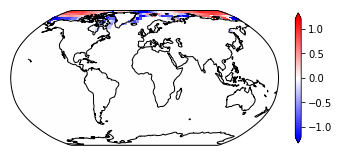

In [48]:
plot_map_vector(X_nonan_arctic[:,800].data,lat_2d,lon_2d)

In [186]:
X_nonan_arctic_mon = np.reshape(X_nonan_arctic,(3240,1001,12))
X_arctic_FMA = X_nonan_arctic_mon[:,:,1:4].reshape(3240,3003) 
X_arctic_ASO = X_nonan_arctic_mon[:,:,7:10].reshape(3240,3003) 

X_arctic_FMA_anom = X_arctic_FMA - np.nanmean(X_arctic_FMA,axis=1)[:,np.newaxis]
X_arctic_ASO_anom = X_arctic_FMA - np.nanmean(X_arctic_ASO,axis=1)[:,np.newaxis]

In [253]:
var.shape, W.shape, X_check.shape

((3240, 1001), (3240, 1), (3240, 3003))

In [255]:
var = X_nonan_arctic_mon[:,:,2] - np.nanmean(X_nonan_arctic_mon[:,:,2],axis=1)[:,np.newaxis]
u,s,v,W = calc_eof(var, lat_2d)

# check SVD
print('checking svd (success for True response)...')
X_check = np.matmul(np.matmul(u,np.diag(s)),v)
print(np.allclose(X_check,W*var))

computing EOFs...
-----------------------------------------------------
completed in 0.6832935810089111 seconds
-----------------------------------------------------
(3240, 1001) (1001,) (1001, 1001)
checking svd (success for True response)...
True


99.99999999999997
fraction in first  20  EOFs =  54.03888364171881


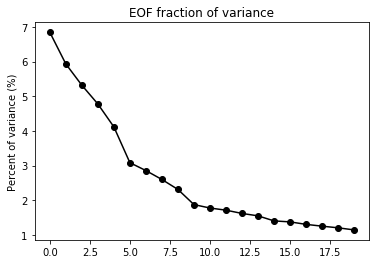

In [256]:
plot_eigenvalues(s,var_to_extract)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


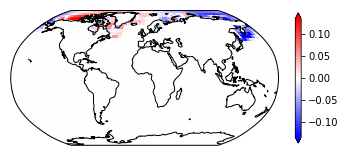

In [257]:
plot_map_vector(-u[:,0],lat_2d,lon_2d)

In [258]:
# project data onto a subset of the EOF basis

# EOF basis
if var_to_extract == 'tos':
    E = u[:,1:nmodes+1]
else:
    E = u[:,0:nmodes]

# project---this doesn't work for tos? masked array/nan issue I don't understand
#P = np.matmul(E.T,X)

# alternative from SVD results. recall v is v.T in numpy. 
# NOTE: this is the projection with W weighting, which is not the same as projecting unweighted data

# 7/13/2020: projection of unweighted data; tos doesn't work with this approach
if var_to_extract == 'tos':
    #P_w = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
    P = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
else:
    #P_w = np.matmul(np.diag(s[0:nmodes]),v[0:nmodes,:])
    P = np.matmul(E.T,var)

9.522112999541116
(3240, 1001)


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


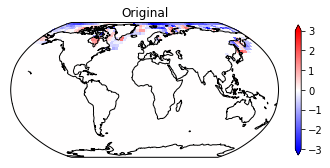

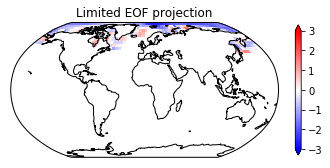

In [260]:
# reconstruct from the limited projection, and compare with the original (error)
check = np.matmul(E,P)
print(np.max(check))
print(check.shape)

# pick a random time to plot
itim = 21

plot_map_vector(var[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Original')
plt.show()
plot_map_vector(check[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Limited EOF projection')
plt.show()

In [261]:
# make sure P has zero mean first !!!
Pzero = np.max(np.abs(np.mean(P,axis=1)))
if Pzero > 1e-6:
    print('warning!!! the projected state does not have zero-mean in the time domain '
         )

In [263]:
ntrain = 500

In [264]:
# prepare the data to train and test the LIM. separate data into training the validation sets 
tsamp = P.shape[1]

train_inds = np.arange(0,ntrain)
valid_inds = np.arange(ntrain,tsamp,1)
x_train = P[:,train_inds]
x_valid = P[:,valid_inds]
print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (20, 500)
validation data shape:  (20, 501)


In [265]:
# climo standardized variance for error normalization in training and validation (1=no skill)
train_var = np.var(np.matmul(E,x_train),axis=1,ddof=1)
valid_var = np.var(np.matmul(E,x_valid),axis=1,ddof=1)

In [266]:
nt = x_train.shape[1]
C_1 = np.matmul(x_train[:,tau:],x_train[:,:-tau].T)/(nt-1)
tau

1

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


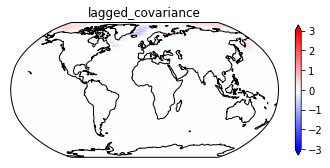

In [267]:
C1_phys_space = np.matmul(C_1,E.T)

plot_map_vector(C1_phys_space[0,:],lat_2d,lon_2d,maxv=3)
plt.title('lagged_covariance')
plt.show()

In [268]:
tau = 1

In [269]:
# train the LIM
LIMd = LIM_train(tau,x_train)

In [270]:
lags

array([0, 1, 2, 3])

In [271]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(4)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
LIMfd_train = LIM_forecast(LIMd,x_train,lags,E)

# validation data
LIMfd_valid = LIM_forecast(LIMd,x_valid,lags,E)

t= 0
t= 1
t= 2
t= 3
t= 0
t= 1
t= 2
t= 3


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


In [272]:
LIMfd_train.keys()

dict_keys(['error', 'x_forecast', 'x_truth_phys_space', 'x_forecast_phys_space'])

In [273]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_error_3d = np.reshape(LIMfd_train['error'],[nlat,nlon,ntims])
LIMfd_valid_error_3d = np.reshape(LIMfd_valid['error'],[nlat,nlon,ntims])

[train_gm_err,
 train_nh_err,
 train_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_train_error_3d,-1,0),lat_2d[:,0])
[train_gm_var,
 train_nh_var,
 train_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(train_var[:,None],[nlat,nlon]),lat_2d[:,0])
[valid_gm_err,
 valid_nh_err,
 valid_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_valid_error_3d,-1,0),lat_2d[:,0])
[valid_gm_var,
 valid_nh_var,
 valid_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None],[nlat,nlon]),lat_2d[:,0])


Text(0.5,1,'LIM normalized global error variance')

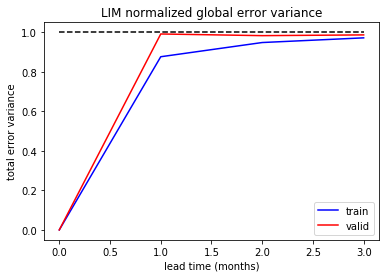

In [274]:
# plot global-mean normalized error variance
plt.plot(lags,train_nh_err/train_nh_var,'b-',label='train')
plt.plot(lags,valid_nh_err/valid_nh_var,'r-',label='valid')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_error_growth_1_6_12months',dpi=300)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


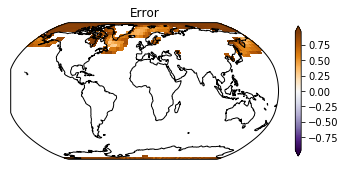

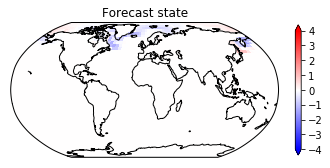

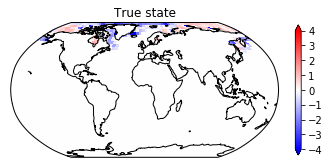

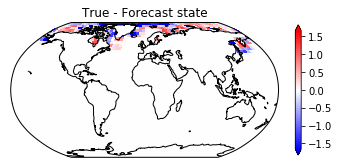

In [217]:
# plot maps of select forecasts and errors for a chosen lag in months (and time, itime)
ilag = 1
plot_map_vector(LIMfd_train['error'][:,ilag]/train_var,lat_2d,lon_2d,cmap='PuOr_r')
plt.title('Error')
plt.show()
itime = 1
plot_map_vector(np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d,minv=-4,maxv=4 )
plt.title('Forecast state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime],lat_2d,lon_2d,minv=-4,maxv=4)
plt.title('True state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime] -np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d)
plt.title('True - Forecast state')
plt.show()

In [219]:
forecast_state_train = np.matmul(E,LIMfd_train['x_forecast']) 
true_state_train = X_arctic_FMA[:,train_inds]
true_state_train.shape, forecast_state_train.shape

((3240, 2000), (13, 3240, 2000))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

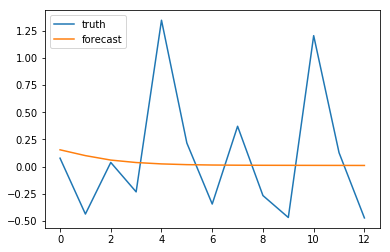

In [220]:
initialt = 1
plt.plot(np.arange(0,13,1),true_state_train[3200,initialt:initialt+13], label='truth')
plt.plot(np.arange(0,13,1),forecast_state_train[:,3200,initialt], label='forecast')
plt.legend()

r = np.zeros(4000-12)

for it in range(4000-12):
    r[it] = np.corrcoef(true_state_train[3000,it:it+13],forecast_state_train[:,3000,it])[0,1]

0.15253532016871182

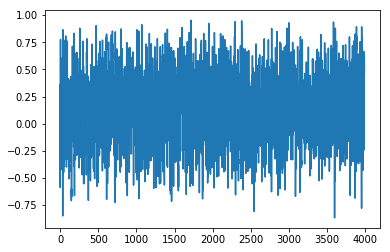

In [254]:
plt.plot(r)
#plt.xlim(3900,4000)
r.mean()

In [142]:
LIMfd_train.keys(), x_valid.shape, E.shape, lags

(dict_keys(['error', 'x_forecast', 'x_truth_phys_space', 'x_forecast_phys_space']),
 (20, 8012),
 (3240, 20),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

In [138]:
LIMfd_train['x_truth_phys_space'].shape,LIMfd_train['x_forecast_phys_space'].shape, LIMfd_train['error'].shape, LIMfd_train['x_forecast'].shape

((3240, 3988), (3240, 3988), (3240, 13), (13, 20, 4000))

In [145]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_truth_3d = np.reshape(LIMfd_train['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_train_forecast_3d = np.reshape(LIMfd_train['x_forecast_phys_space'],[nlat,nlon,3988])
LIMfd_valid_truth_3d = np.reshape(LIMfd_valid['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_valid_forecast_3d = np.reshape(LIMfd_valid['x_forecast_phys_space'],[nlat,nlon,3988])

[train_truth_gm,
 train_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_truth_3d,lat_2d[:,0])
[train_forecast_gm,
 train_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_forecast_3d,lat_2d[:,0])
[valid_truth_gm,
 valid_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_truth_3d,lat_2d[:,0])
[valid_forecast_gm,
 valid_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_forecast_3d,lat_2d[:,0])



ValueError: cannot reshape array of size 25920000 into shape (45,72,3988)

## Independent validation: 

In [39]:
# load 20cr data for independent validation...
data_20cr,_,_ = get_data(var_to_extract,infile_20cr_tas, 45, 72)
ntime_20cr = data_20cr.shape[0]

fetching  tas  from  /home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc
-----------------------------------------------------
completed in 0.7526452541351318 seconds
-----------------------------------------------------
(1932, 91, 180)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 91
nlon: 180
(16380, 1932)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 0.3795194625854492 seconds
-----------------------------------------------------
Working on:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11


In [41]:
# back to (nx,ntime)
X_20cr = np.moveaxis(np.reshape(data_20cr,[ntime_20cr,nlat*nlon]),0,-1) 

# test the LIM on 20CR monthly data projected on the same basis
P_20cr = np.matmul(E.T,X_20cr)

# climo standardized variance
valid_var_20cr = np.var(np.matmul(E,P_20cr),axis=1,ddof=1)

In [43]:
# CCSM LIM forecasts on 20cr states
LIMfd_20cr = LIM_forecast(LIMd,P_20cr,lags,E)

t= 0
t= 1


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


In [44]:
# proper area-weighted global-mean values
valid_gm_err_20cr,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_20cr['error'],[nlat,nlon,ntims]),-1,0),lat_2d[:,0])
valid_gm_var_20cr,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_20cr[:,None],[nlat,nlon]),lat_2d[:,0])


Text(0.5,1,'LIM normalized global error variance')

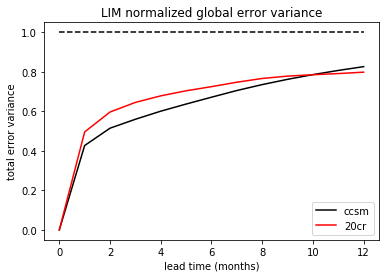

In [45]:
plt.plot(lags,valid_gm_err/valid_gm_var,'k-',label='ccsm')
plt.plot(lags,valid_gm_err_20cr/valid_gm_var_20cr,'r-',label='20cr')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_forecast_error_ccsm_20cr_6mo',dpi=300)